# Preprocessing of Enrollment.csv and Budget.csv

In [ ]:
from google.colab import files

uploaded = files.upload()


In [ ]:
import pandas as pd

enroll_raw = pd.read_csv("Enrollment.csv", header=None)
budget_raw = pd.read_csv("Budget.csv", header=None)

print("=== Enrollment Preview ===")
print(enroll_raw.head(15))
print("\n=== Budget Preview ===")
print(budget_raw.head(15))


FileNotFoundError: [Errno 2] No such file or directory: 'Enrollment.csv'

In [ ]:
import pandas as pd
import re
from google.colab import files

enroll_raw = pd.read_csv("Enrollment.csv", header=None)
budget_raw = pd.read_csv("Budget.csv", header=None)

def find_header_row(df):
    for i in range(len(df)):
        row_str = " ".join(df.iloc[i].astype(str).values)
        if "Region" in row_str:
            return i
    raise ValueError("No header row found!")

enroll_header_row = find_header_row(enroll_raw)
budget_header_row = find_header_row(budget_raw)

enroll_df = enroll_raw.iloc[enroll_header_row + 1:, 1:7].copy()
enroll_df.columns = ["region", "institution_type", "enrolled_students", "faculty", "ratio", "year"]

budget_df = budget_raw.iloc[budget_header_row + 1:, 1:7].copy()
budget_df.columns = ["region", "personnel", "maintenance", "capital_outlays", "total", "year"]

enroll_df = enroll_df.dropna(how="all").applymap(lambda x: x.strip() if isinstance(x, str) else x)
budget_df = budget_df.dropna(how="all").applymap(lambda x: x.strip() if isinstance(x, str) else x)

num_cols_enroll = ["enrolled_students", "faculty"]
num_cols_budget = ["personnel", "maintenance", "capital_outlays", "total"]

for col in num_cols_enroll:
    enroll_df[col] = enroll_df[col].replace({",": ""}, regex=True).astype(float)

for col in num_cols_budget:
    budget_df[col] = budget_df[col].replace({",": ""}, regex=True).astype(float)

def standardize_region(name):
    if pd.isna(name):
        return name
    name = str(name).lower()
    name = re.sub(r"^\d+\s*-\s*", "", name)
    name = name.replace(".", "").strip()

    mapping = {
        "ilocos": "Region I - Ilocos Region",
        "cagayan": "Region II - Cagayan Valley",
        "central luzon": "Region III - Central Luzon",
        "calabarzon": "Region IV-A - CALABARZON",
        "mimaropa": "Region IV-B - MIMAROPA",
        "bicol": "Region V - Bicol Region",
        "western visayas": "Region VI - Western Visayas",
        "central visayas": "Region VII - Central Visayas",
        "eastern visayas": "Region VIII - Eastern Visayas",
        "zamboanga": "Region IX - Zamboanga Peninsula",
        "northern mindanao": "Region X - Northern Mindanao",
        "davao": "Region XI - Davao Region",
        "soccsksargen": "Region XII - SOCCSKSARGEN",
        "socsksargen": "Region XII - SOCCSKSARGEN",
        "caraga": "Region XIII - Caraga",
        "cordillera": "CAR - Cordillera Administrative Region",
        "ncr": "NCR - National Capital Region",
        "nat": "NCR - National Capital Region",
        "capital": "NCR - National Capital Region",
        "barmm": "BARMM - Bangsamoro Autonomous Region in Muslim Mindanao",
        "armm": "BARMM - Bangsamoro Autonomous Region in Muslim Mindanao"
    }

    for key, val in mapping.items():
        if key in name:
            return val
    return name.title()

enroll_df["region"] = enroll_df["region"].apply(standardize_region)
budget_df["region"] = budget_df["region"].apply(standardize_region)

exclude_regions = [
    "ARMM - Bangsamoro Autonomous Region in Muslim Mindanao",
    "BARMM - Bangsamoro Autonomous Region in Muslim Mindanao",
    "Armm"
]
enroll_df = enroll_df[~enroll_df["region"].isin(exclude_regions)]
budget_df = budget_df[~budget_df["region"].isin(exclude_regions)]

# Compute student-to-faculty ratio
enroll_df["ratio_value"] = enroll_df["enrolled_students"] / enroll_df["faculty"]
enroll_df["ratio"] = enroll_df["ratio_value"].apply(lambda x: f"1:{x:.1f}")

# Aggregate enrollment and budget by region/year
enroll_summary = enroll_df.groupby(["region", "year"], as_index=False).agg({
    "enrolled_students": "sum",
    "faculty": "sum"
})
enroll_summary["ratio_value"] = enroll_summary["enrolled_students"] / enroll_summary["faculty"]
enroll_summary["ratio"] = (enroll_summary["ratio_value"]).round().astype(int).apply(lambda x: f"1:{x}")

budget_summary = budget_df.groupby(["region", "year"], as_index=False).agg({
    "personnel": "sum",
    "maintenance": "sum",
    "capital_outlays": "sum",
    "total": "sum"
})

budget_summary = budget_summary.rename(columns={
    "personnel": "Personnel Budget (PHP)",
    "maintenance": "Maintenance & Other Expenses (PHP)",
    "capital_outlays": "Capital Outlays (PHP)",
    "total": "Total Budget (PHP)"
})

merged_df = pd.merge(
    enroll_summary,
    budget_summary,
    on=["region", "year"],
    how="inner"
)

merged_df.columns = [
    "Region", "Year", "Enrolled Students", "Faculty", "Ratio", "Ratio Value",
    "Personnel Budget (PHP)", "Maintenance & Other Expenses (PHP)",
    "Capital Outlays (PHP)", "Total Budget (PHP)"
]

enroll_summary.to_csv("Enrollment_Clean.csv", index=False)
budget_summary.to_csv("Budget_Clean.csv", index=False)
merged_df.to_csv("Enrollment_Budget_Merged.csv", index=False)

files.download("Enrollment_Clean.csv")
files.download("Budget_Clean.csv")
files.download("Enrollment_Budget_Merged.csv")

print(enroll_summary.head())
print(budget_summary.head())
print(merged_df.head())


In [ ]:
from google.colab import files
uploaded = files.upload()

import pandas as pd

merged_df = pd.read_csv("Enrollment_Budget_Merged.csv")



Saving Enrollment_Budget_Merged.csv to Enrollment_Budget_Merged.csv


# **Question 1**

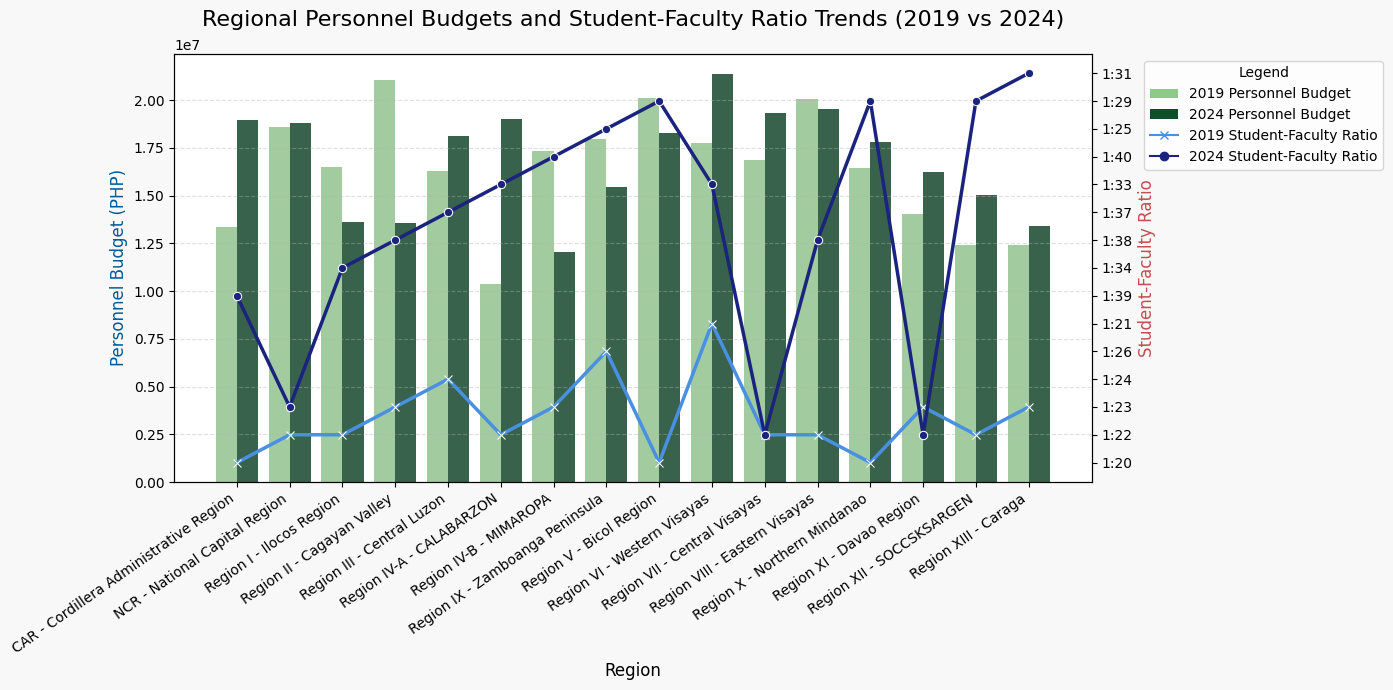

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

summary_df = merged_df.groupby(["Region", "Year"], as_index=False).agg({
    "Personnel Budget (PHP)": "sum",
    "Ratio Value": "sum"
})

plt.figure(figsize=(14,7), facecolor="#f8f8f8")

ax1 = sns.barplot(
    data=summary_df,
    x="Region",
    y="Personnel Budget (PHP)",
    hue="Year",
    palette=["#8ACB88", "#0E4E2B"],
    alpha=0.85
)

ax2 = ax1.twinx()

# Plot 2019
sns.lineplot(
    data=summary_df[summary_df["Year"]==2019],
    x="Region",
    y="Ratio Value",
    color="#4A90E2",
    marker='x',
    linewidth=2.5,
    ax=ax2,
    label="2019 Student-Faculty Ratio"
)

# Plot 2024
sns.lineplot(
    data=summary_df[summary_df["Year"]==2024],
    x="Region",
    y="Ratio Value",
    color="#1A237E",
    marker='o',
    linewidth=2.5,
    ax=ax2,
    label="2024 Student-Faculty Ratio"
)

ax1.legend_.remove()
ax2.legend_.remove()

legend_elements = [
    Patch(facecolor="#8ACB88", label="2019 Personnel Budget"),
    Patch(facecolor="#0E4E2B", label="2024 Personnel Budget"),
    Line2D([0], [0], color="#4A90E2", marker='x', label="2019 Student-Faculty Ratio"),
    Line2D([0], [0], color="#1A237E", marker='o', label="2024 Student-Faculty Ratio")
]

ax1.legend(
    handles=legend_elements,
    title="Legend",
    bbox_to_anchor=(1.05, 1),
    loc='upper left'
)

ax1.set_title("Regional Personnel Budgets and Student-Faculty Ratio Trends (2019 vs 2024)", fontsize=16, pad=20)
ax1.set_xlabel("Region", fontsize=12)
ax1.set_ylabel("Personnel Budget (PHP)", color="#005B96", fontsize=12)
ax2.set_ylabel("Student-Faculty Ratio", color="#C44E52", fontsize=12)
ax2.invert_yaxis()


plt.setp(ax1.get_xticklabels(), rotation=35, ha="right", fontsize=10)
ax1.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


# **Question 2**

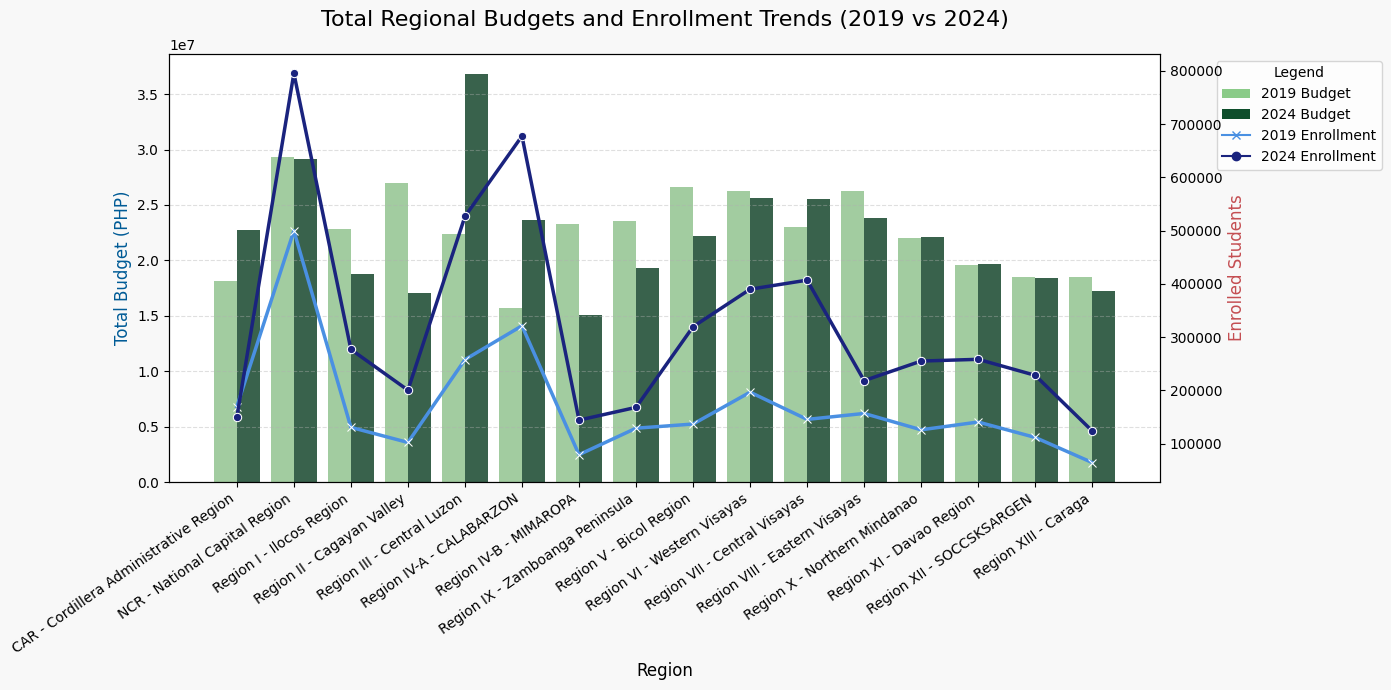

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

# Aggregate total budget and enrollment per region and year
summary_df = merged_df.groupby(["Region", "Year"], as_index=False).agg({
    "Total Budget (PHP)": "sum",
    "Enrolled Students": "sum"
})

plt.figure(figsize=(14,7), facecolor="#f8f8f8")

# Bar Plot for Budget
ax1 = sns.barplot(
    data=summary_df,
    x="Region",
    y="Total Budget (PHP)",
    hue="Year",
    palette=["#8ACB88", "#0E4E2B"],
    alpha=0.85
)

# Line Plot for Enrollment
ax2 = ax1.twinx()

# Plot 2019
sns.lineplot(
    data=summary_df[summary_df["Year"]==2019],
    x="Region",
    y="Enrolled Students",
    color="#4A90E2",
    marker='x',
    linewidth=2.5,
    ax=ax2,
    label="2019 Enrollment"
)

# Plot 2024
sns.lineplot(
    data=summary_df[summary_df["Year"]==2024],
    x="Region",
    y="Enrolled Students",
    color="#1A237E",
    marker='o',
    linewidth=2.5,
    ax=ax2,
    label="2024 Enrollment"
)

ax1.legend_.remove()
ax2.legend_.remove()

legend_elements = [
    Patch(facecolor="#8ACB88", label="2019 Budget"),
    Patch(facecolor="#0E4E2B", label="2024 Budget"),
    Line2D([0], [0], color="#4A90E2", marker='x', label="2019 Enrollment"),
    Line2D([0], [0], color="#1A237E", marker='o', label="2024 Enrollment")
]

ax1.legend(
    handles=legend_elements,
    title="Legend",
    bbox_to_anchor=(1.05, 1),
    loc='upper left'
)

ax1.set_title("Total Regional Budgets and Enrollment Trends (2019 vs 2024)", fontsize=16, pad=20)
ax1.set_xlabel("Region", fontsize=12)
ax1.set_ylabel("Total Budget (PHP)", color="#005B96", fontsize=12)
ax2.set_ylabel("Enrolled Students", color="#C44E52", fontsize=12)


plt.setp(ax1.get_xticklabels(), rotation=35, ha="right", fontsize=10)
ax1.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


**Enrollment vs Faculty**

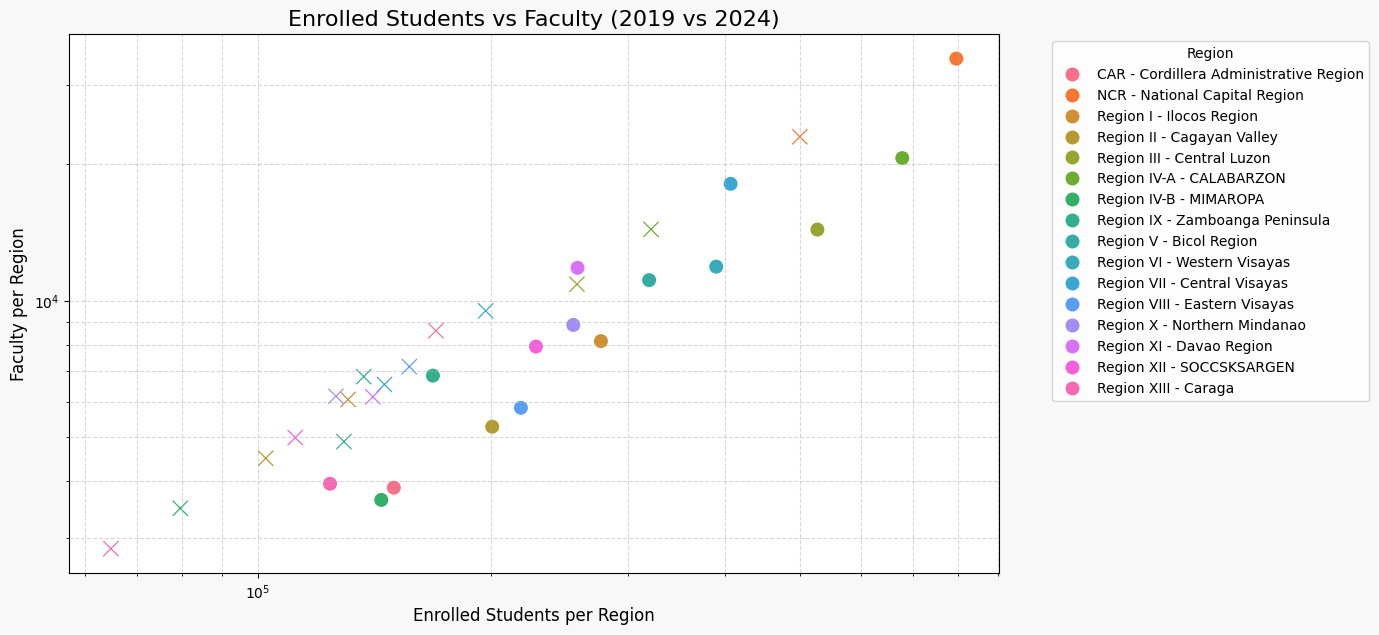

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,7), facecolor="#f8f8f8")


# Scatter plot for 2019
sns.scatterplot(
    data=merged_df[merged_df["Year"] == 2019],
    x="Enrolled Students",
    y="Faculty",
    hue="Region",
    style="Region",
    markers=["x"]*len(merged_df["Region"].unique()),  # x for 2019
    s=120,
    legend=False
)

# Scatter plot for 2024
sns.scatterplot(
    data=merged_df[merged_df["Year"] == 2024],
    x="Enrolled Students",
    y="Faculty",
    hue="Region",
    style="Region",
    markers=["o"]*len(merged_df["Region"].unique()),  # circles for 2024
    s=120,
    legend="full"
)

plt.xscale('log')
plt.yscale('log')
plt.title("Enrolled Students vs Faculty (2019 vs 2024)", fontsize=16)
plt.xlabel("Enrolled Students per Region", fontsize=12)
plt.ylabel("Faculty per Region", fontsize=12)
plt.grid(True, which="both", linestyle="--", alpha=0.5)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Region")
plt.show()






# Nutshell Plot

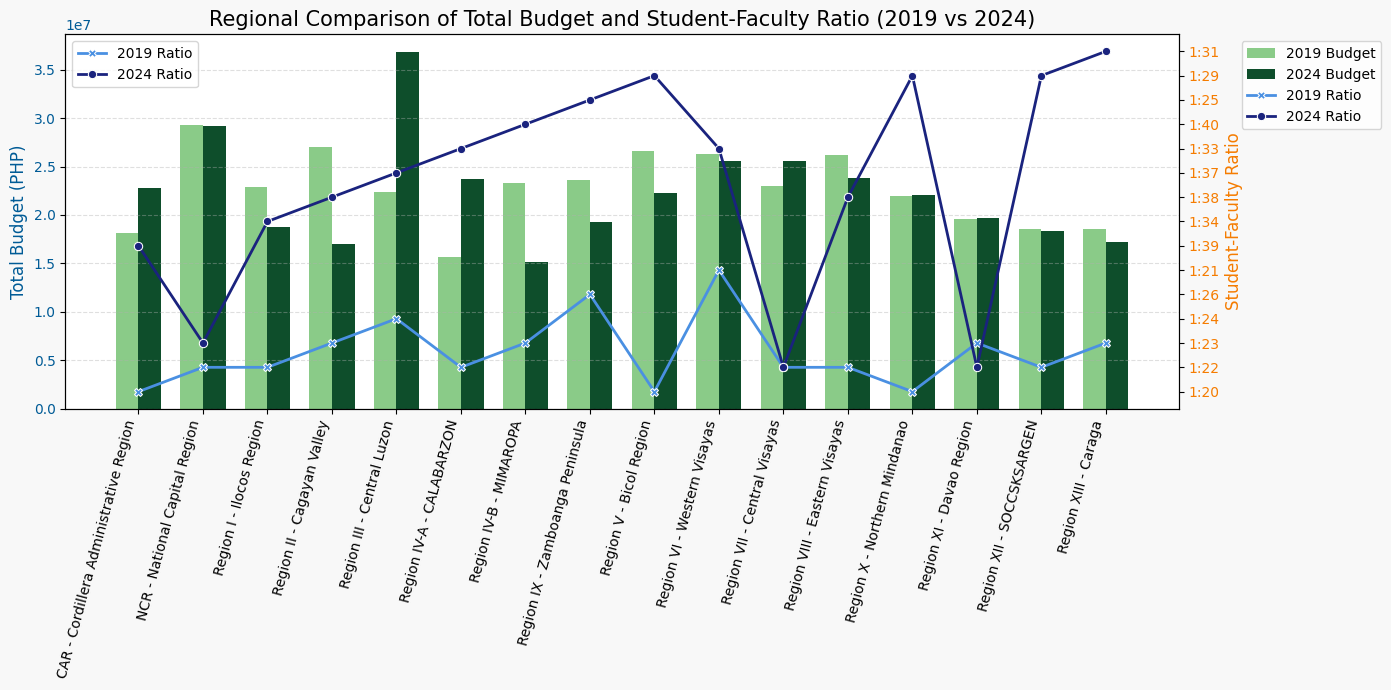

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df = merged_df.copy()
regions = df["Region"].unique()
df = df.sort_values(["Region", "Year"])

fig, ax1 = plt.subplots(figsize=(14, 7), facecolor="#f8f8f8")

x = np.arange(len(regions))
width = 0.35

# Plot Total Budget (bars)
ax1.bar(
    x - width/2,
    df[df["Year"] == 2019]["Total Budget (PHP)"],
    width=width,
    label="2019 Budget",
    color="#8ACB88"
)
ax1.bar(
    x + width/2,
    df[df["Year"] == 2024]["Total Budget (PHP)"],
    width=width,
    label="2024 Budget",
    color="#0E4E2B"
)
ax1.set_ylabel("Total Budget (PHP)", color="#005B96", fontsize=12)
ax1.tick_params(axis="y", labelcolor="#005B96")

# Plot Student-Faculty Ratio (line)
ax2 = ax1.twinx()
sns.lineplot(
    data=df[df["Year"] == 2019],
    x=x,
    y="Ratio Value",
    label="2019 Ratio",
    color="#4A90E2",
    marker="X",
    linewidth=2,
    ax=ax2
)
sns.lineplot(
    data=df[df["Year"] == 2024],
    x=x,
    y="Ratio Value",
    label="2024 Ratio",
    color="#1A237E",
    marker="o",
    linewidth=2,
    ax=ax2
)
ax2.set_ylabel("Student-Faculty Ratio", color="#F57C00", fontsize=12)
ax2.tick_params(axis="y", labelcolor="#F57C00")
ax2.invert_yaxis()

ax1.set_xticks(x)
ax1.set_xticklabels(regions, rotation=75, ha="right")
ax1.set_title("Regional Comparison of Total Budget and Student-Faculty Ratio (2019 vs 2024)", fontsize=15)
ax1.grid(True, axis="y", linestyle="--", alpha=0.4)

handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(handles1 + handles2, labels1 + labels2, loc="upper left", bbox_to_anchor=(1.05, 1))

plt.tight_layout()
plt.show()


#HYPOTHESIS TESTING


In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_rel, spearmanr
import matplotlib.pyplot as plt
import seaborn as sns

# Data Prep
df_2019 = merged_df[merged_df["Year"] == 2019].copy()
df_2024 = merged_df[merged_df["Year"] == 2024].copy()

print(f"2019 regions: {len(df_2019)}")
print(f"2024 regions: {len(df_2024)}")

# Merge to compare regions in both years
common_regions = set(df_2019['Region']).intersection(set(df_2024['Region']))
df_2019_common = df_2019[df_2019['Region'].isin(common_regions)]
df_2024_common = df_2024[df_2024['Region'].isin(common_regions)]

print(f"Common regions in both years: {len(common_regions)}")

# Calculate changes between yrs
comparison_df = pd.DataFrame()
comparison_df['Region'] = df_2019_common['Region'].values
comparison_df['Personnel_Budget_Change'] = df_2024_common['Personnel Budget (PHP)'].values - df_2019_common['Personnel Budget (PHP)'].values
comparison_df['Total_Budget_Change'] = df_2024_common['Total Budget (PHP)'].values - df_2019_common['Total Budget (PHP)'].values # NEW LINE
comparison_df['Ratio_Change'] = df_2024_common['Ratio'].values - df_2019_common['Ratio'].values
comparison_df['Personnel_Budget_Change_Pct'] = (comparison_df['Personnel_Budget_Change'] / df_2019_common['Personnel Budget (PHP)'].values) * 100
comparison_df['Total_Budget_Change_Pct'] = (comparison_df['Total_Budget_Change'] / df_2019_common['Total Budget (PHP)'].values) * 100 # NEW LINE
comparison_df['Enrollment_Change'] = df_2024_common['Enrolled Students'].values - df_2019_common['Enrolled Students'].values
comparison_df['Enrollment_Change_Pct'] = (comparison_df['Enrollment_Change'] / df_2019_common['Enrolled Students'].values) * 100

# RQ1: Budget Allocation vs Education Quality
print("RESEARCH QUESTION 1: Budget Allocation vs Education Quality")
print("H0: No relationship between budget allocation and faculty-student ratios")
print("H1: Significant relationship exists")
print()

print("Budget Changes vs Ratio Changes (2019 -> 2024):")
print(comparison_df[['Region', 'Personnel_Budget_Change_Pct', 'Ratio_Change']].round(2))

# Spearman correlation: budget vs ratios
corr_budget_ratio, p_budget_ratio = spearmanr(comparison_df['Personnel_Budget_Change_Pct'], comparison_df['Ratio_Change'])

print(f"Spearman Correlation between Budget Change % and Ratio Change: r = {corr_budget_ratio:.3f}, p = {p_budget_ratio:.4f}")

if p_budget_ratio < 0.05:
    print("Result: Reject H0 - Significant relationship found")
    if corr_budget_ratio > 0:
        print("Interpretation: Increased budget associated with WORSENING ratios")
    else:
        print("Interpretation: Increased budget associated with IMPROVING ratios")
else:
    print("Result: Fail to reject H0 - No significant relationship")

# Check overall ratio changes with paired t-test
t_ratio, p_ratio = ttest_rel(df_2019_common['Ratio'], df_2024_common['Ratio'])
mean_ratio_2019 = df_2019_common['Ratio'].mean()
mean_ratio_2024 = df_2024_common['Ratio'].mean()
print(f"\nOverall Ratio Change (Paired t-test):")
print(f"2019 Mean Ratio: {mean_ratio_2019:.2f} : 1")
print(f"2024 Mean Ratio: {mean_ratio_2024:.2f} : 1")
print(f"t = {t_ratio:.3f}, p = {p_ratio:.4f}")

if p_ratio < 0.05:
    if mean_ratio_2024 > mean_ratio_2019:
        print("Significant worsening of faculty-student ratios from 2019 to 2024")
    else:
        print("Significant improvement in faculty-student ratios from 2019 to 2024")
else:
    print("No significant change in faculty-student ratios overall")


print("The analysis found no significant relationship between changes in personnel budgets and changes in student-teacher ratios, indicating that simply increasing funding for personnel has not been an effective strategy for improving class sizes. Despite an average personnel budget increase of 7.24%, the student-teacher ratio worsened significantly across all regions, rising from 22:1 to 31:1, which suggests that budget increases were insufficient to keep pace with massive enrollment growth or were not allocated specifically to hiring new faculty.")
# RQ2: Enrollment (Access) vs Budget Allocation
print("RESEARCH QUESTION 2: Access Disparities vs Budget Allocation")
print("H0: No relationship between enrollment growth and budget allocation")
print("H1: Significant relationship exists")
print()

# Identify regions with highest/lowest access
print("ACCESS DISPARITIES ANALYSIS")
top_access_regions = comparison_df.nlargest(5, 'Enrollment_Change_Pct')
bottom_access_regions = comparison_df.nsmallest(5, 'Enrollment_Change_Pct')

print("Top 5 Regions by Enrollment Growth (Highest Access Improvement):")
print(top_access_regions[['Region', 'Enrollment_Change_Pct', 'Total_Budget_Change_Pct']].round(2)) # CHANGED COLUMN

print("\nBottom 5 Regions by Enrollment Growth (Lowest Access Improvement):")
print(bottom_access_regions[['Region', 'Enrollment_Change_Pct', 'Total_Budget_Change_Pct']].round(2)) # CHANGED COLUMN

# Relationship between access and budget using Spearman correlation
corr_access_budget, p_access_budget = spearmanr(comparison_df['Enrollment_Change_Pct'], comparison_df['Total_Budget_Change_Pct']) # CHANGED COLUMN

print(f"\nSpearman Correlation between Enrollment Change % and Total Budget Change %: r = {corr_access_budget:.3f}, p = {p_access_budget:.4f}") # UPDATED PRINT

if p_access_budget < 0.05:
    print("Result: Reject H0 - Significant relationship found")
    if corr_access_budget > 0:
        print("Interpretation: Regions with enrollment growth received TOTAL BUDGET increases") # UPDATED PRINT
    else:
        print("Interpretation: Regions with enrollment growth received TOTAL BUDGET decreases") # UPDATED PRINT
else:
    print("Result: Fail to reject H0 - No significant relationship")

# Budget analysis
mean_budget_high_access = top_access_regions['Total_Budget_Change_Pct'].mean() # CHANGED COLUMN
mean_budget_low_access = bottom_access_regions['Total_Budget_Change_Pct'].mean() # CHANGED COLUMN

print(f"\nBudget Equity Analysis:")
print(f"High access growth regions: {mean_budget_high_access:.2f}% TOTAL budget change") # UPDATED PRINT
print(f"Low access growth regions: {mean_budget_low_access:.2f}% TOTAL budget change") # UPDATED PRINT

if mean_budget_high_access > mean_budget_low_access:
    print("TOTAL Budget allocation favors regions with improving access") # UPDATED PRINT
elif mean_budget_high_access < mean_budget_low_access:
    print("TOTAL Budget allocation favors regions with stagnant access") # UPDATED PRINT
else:
    print("TOTAL Budget allocation is equal across access levels") # UPDATED PRINT

print("The study revealed no strong statistical link between a region's enrollment growth and its change in total budget, showing that funding has not been systematically proportional to student population increases. However, a positive equity trend was identified, as the regions with the highest enrollment growth received a slight average budget increase of 5.42%, while those with the lowest growth saw their budgets cut by an average of 7.51%, suggesting a partial but weak policy response to access disparities.")
# Summary
print("SUMMARY STATISTICS")
print(f"Average Personnel Budget Change (2019-2024): {comparison_df['Personnel_Budget_Change_Pct'].mean():.2f}%")
print(f"Average Total Budget Change (2019-2024): {comparison_df['Total_Budget_Change_Pct'].mean():.2f}%") # NEW LINE
print(f"Average Enrollment Change (2019-2024): {comparison_df['Enrollment_Change_Pct'].mean():.2f}%")
print(f"Average Ratio Change (2019-2024): {comparison_df['Ratio_Change'].mean():.2f} points")

2019 regions: 16
2024 regions: 16
Common regions in both years: 16
RESEARCH QUESTION 1: Budget Allocation vs Education Quality
H0: No relationship between budget allocation and faculty-student ratios
H1: Significant relationship exists

Budget Changes vs Ratio Changes (2019 -> 2024):
                                    Region  Personnel_Budget_Change_Pct  \
0   CAR - Cordillera Administrative Region                        41.87   
1            NCR - National Capital Region                         1.18   
2                 Region I - Ilocos Region                       -17.52   
3               Region II - Cagayan Valley                       -35.52   
4               Region III - Central Luzon                        11.11   
5                 Region IV-A - CALABARZON                        83.08   
6                   Region IV-B - MIMAROPA                       -30.62   
7          Region IX - Zamboanga Peninsula                       -13.89   
8                  Region V - Bicol Regi